[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Intro

[*Intro to tracking slides*](https://docs.google.com/presentation/d/1yCOw8qApO_4FTbd-7CxQ23jfhIYb9FrJBoB84Pp1C8Q/edit?usp=sharing)


Kalman and Bayesian Filters in Python <br>
https://github.com/rlabbe

Open source book (Creative Commons 4.0) <br> by Rogger Labber


Silicon Valley engineer from Clarkson University (NY)

Based on Mr. Labbe's online profile:

- Lead software developer for augmented reality applications

- Designer and sole software engineer for an Augmented Reality Binocular System(ARBS) for the Air Force.

- Lead developer on a multinocular computer vision system which tracks all movements of baseball players and the ball during a game.

- Upgraded and fielded a paper Band Inspection System for Philip Morris, which uses machine vision to detect defects in paper.

- Sole inventor and developer of
    - Mission Analysis and Review System (MARS);
    - Digital Flight Planning System (DFPS), a GIS product for military flight planning

- Many other software development with GPS and INS processing

Thanks for all your work on publishing your introductory text on Kalman Filtering, as well as the Python Kalman Filtering libraries. We’ve been using it internally to teach some key state estimation concepts to folks and it’s been a huge help.
- Sam Rodkey,
Lead Propulsion Engineer, SpaceX

# The g-h Filter
## ($\alpha - \beta$ Filter)

In [3]:
# # Colab makeup

# Clone the book repo
!git clone https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python.git
# Change into the repo directory
%cd Kalman-and-Bayesian-Filters-in-Python
# Install requirements (optional, but good to have)
!pip install -r requirements.txt
# Add repo to Python path
import sys
sys.path.append('/content/Kalman-and-Bayesian-Filters-in-Python')
print("Finished setup!")

Cloning into 'Kalman-and-Bayesian-Filters-in-Python'...
remote: Enumerating objects: 7036, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 7036 (delta 35), reused 25 (delta 25), pack-reused 6984 (from 3)
Receiving objects: 100% (7036/7036), 585.21 MiB | 30.41 MiB/s, done.
Resolving deltas: 100% (3853/3853), done.
/home/evelyn/vs-code-workspace/embedded_ai/jupiter notebook/Kalman-and-Bayesian-Filters-in-Python/Kalman-and-Bayesian-Filters-in-Python
Finished setup!


In [4]:
# # Colab makeup

#format the book
from __future__ import division, print_function
%matplotlib inline
import runpy
runpy.run_path('book_format.py')

ModuleNotFoundError: No module named 'distutils'

## Building Intuition via Thought Experiments

Imagine that we live in a world without scales - the devices you stand on to weigh yourself. One day at work a co-worker comes running up to you and announces her invention of a 'scale' to you.

After she explains, you eagerly stand on it and announce the results: "172 lbs". You are ecstatic - for the first time in your life you know what you weigh.

More importantly, dollar signs dance in your eyes as you imagine selling this device to weight loss clinics across the world! This is fantastic!

Another co-worker hears the commotion and comes over to find out what has you so excited. You explain the invention and once again step onto the scale, and proudly proclaim the result: "161 lbs." And then you hesitate, confused.

"It read 172 lbs a few seconds ago", you complain to your co-worker.

"I never said it was accurate," she replies.

Sensors are inaccurate.

This is the motivation behind a huge body of work in filtering, and solving this problem is the topic of this book.

I could just provide the solutions that have been developed over the last half century, but these solutions were developed by asking very basic, fundamental questions into the nature of what we know and how we know it.

Before we attempt the math, let's follow that journey of discovery, and see if it informs our intuition about filtering.

**Try Another Scale**

Is there any way we can improve upon this result?

The obvious, first thing to try is get a better sensor. Unfortunately, your co-worker informs you that she has built 10 scales, and they all operate with about the same accuracy.

You have her bring out another scale, and you weigh yourself on one, and then on the other. The first scale (A) reads "160 lbs", and the second (B) reads "170 lbs".

What can we conclude about your weight?

Well, what are our choices?

* We could choose to only believe A, and assign 160lbs to our weight estimate.
* We could choose to only believe B, and assign 170lbs to our weight.
* We could choose a number less than both A and B.
* We could choose a number greater than both A and B.
* We could choose a number between A and B.

The first two choices are plausible, but we have no reason to favor one scale over the other. Why would we choose to believe A instead of B? We have no reason for such a belief.

The third and fourth choices are irrational. The scales are admittedly not very accurate, but there is no reason at all to choose a number outside of the range of what they both measured.

The final choice is the only reasonable one. If both scales are inaccurate, and as likely to give a result above my actual weight as below it, more often than not the answer is somewhere between A and B.

In mathematics this concept is formalized as [*expected value$^1$*](https://en.wikipedia.org/wiki/Expected_value), and we will cover it in depth later.

$^1$ "the long-run average value of repetitions of the experiment"

For now ask yourself what would be the 'usual' thing to happen if we took one million readings.
- Some of the times both scales will read too low,
- sometimes both will read too high, and
- the rest of the time they will straddle the actual weight.

If they straddle the actual weight then certainly we should choose a number between A and B.

If they don't straddle then we don't know if they are both too high or low, but by choosing a number between A and B we at least mitigate the effect of the worst measurement.

For example, suppose our actual weight is 180 lbs. <br> 160 lbs is a big error. But if we choose a weight between 160 lbs and 170 lbs our estimate will be better than 160 lbs. <br>The same argument holds if both scales returned a value greater than the actual weight.

We will deal with this more formally later, but for now I hope it is clear that our best estimate is the average of A and B. $\frac{160+170}{2} = 165$.

We can look at this graphically.

I have plotted the measurements of A and B with an assumed error of $\pm$ 8 lbs.

The measurements falls between 160 and 170 so the only weight that makes sense must lie within 160 and 170 lbs.

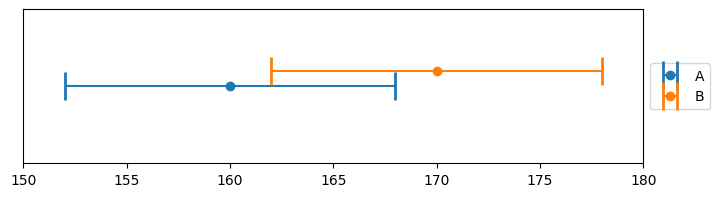

In [ ]:
import kf_book.book_plots as book_plots
from kf_book.book_plots import plot_errorbars
plot_errorbars([(160, 8, 'A'), (170, 8, 'B')], xlims=(150, 180))

Which region would be a good estimate?

A word on how I generated this plot. I import code from the module book_plots in the `kf_book` subdirectory. Generating this plot takes a lot of boilerplate Python that isn't interesting to read. I take this tack often in the book. When the cell is run `plot_errorbars()` gets called and the plot is inserted into the book.

If you want to view the code for plot_errorbars ...:

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/kf_book/book_plots.py
```Python

    plot_errorbars??
```
or
```Python
    plot_errorbars?
```

So 165 lbs looks like a reasonable estimate, but there is more information here that we might be able to take advantage of.

The only weights that are possible lie in the intersection between the error bars of A and B.

For example, a weight of 161 lbs is impossible because scale B could not give a reading of 170 lbs with a maximum error of 8 pounds.

Likewise a weight of 169 lbs is impossible because scale A could not give a reading of 160 lbs with a maximum error of 8 lbs. In this example the only possible weights lie in the range of 162 to 168 lbs.

That doesn't yet allow us to find a better weight estimate, but let's play 'what if' some more.

What if we are now told that A is three times more accurate than B?

Consider the 5 options we listed above. It still makes no sense to choose a number outside the range of A and B, so we will not consider those.

It perhaps seems more compelling to choose A as our estimate - after all, we know it is more accurate, why not use it instead of B?

Can B possibly improve our knowledge over A alone?

The answer, perhaps counter intuitively, is yes, it can.

First, let's look at the same measurements of A=160 and B=170, but with the error of A $\pm$ 3 lbs and the error of B is 3 times as much, $\pm$ 9 lbs.

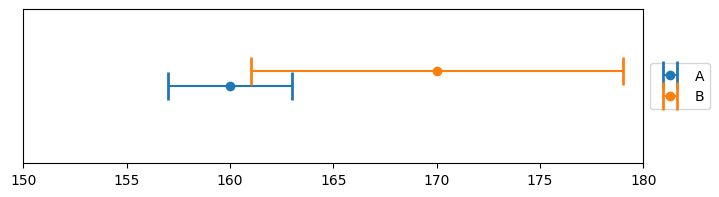

In [ ]:
plot_errorbars([(160, 3, 'A'), (170, 9, 'B')], xlims=(150, 180))

The overlap of the error bars of A and B are the only possible true weight.

This overlap is smaller than the error in A alone.

More importantly, in this case we can see that the overlap doesn't include 160 lbs or 165 lbs.

If we only used the measurement from A because it is more accurate than B we would give an estimate of 160 lbs.

If we average A and B we would get 165 lbs. Neither of those weights are possible given our knowledge of the accuracy of the scales.

By including the measurement of B we would give an estimate somewhere between 161 lbs and 163 lbs, the limits of the intersections of the two error bars.

Let's take this to the extreme limits.  

Assume we know scale A is accurate to 1 lb. In other words, if we truly weigh 170 lbs, it could report 169, 170, or 171 lbs.

We also know that scale B is accurate to 9 lbs. We do a weighing on each scale, and get A=160, and B=170.

What should we estimate our weight to be? Let's look at that graphically.

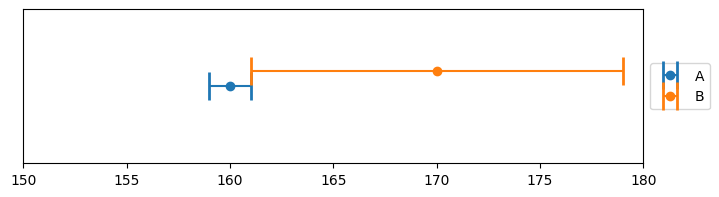

In [ ]:
plot_errorbars([(160, 1, 'A'), (170, 9, 'B')], xlims=(150, 180))

Here we can see that the only possible weight is 161 lbs. This is an important result.

With two relatively inaccurate sensors we are able to deduce an extremely accurate result.

**So two sensors, even if one is less accurate than the other, is better than one.**

I will harp on this for the remainder of the book. We never throw information away, no matter how poor it is.

We will be developing math and algorithms that allow us to include all possible sources of information to form the best estimate possible.

However, we have strayed from our problem.

No customer is going to want to buy multiple scales,

and besides, we initially started with an assumption that all scales were equally (in)accurate.

This insight of using all measurements regardless of accuracy will play a large role later, so don't forget it.

What if I have one scale, but I weigh myself many times?

We concluded that if we had two scales of equal accuracy we should average the results of their measurements.

What if I weigh myself 10,000 times with one scale?

We have already stated that the scale is equally likely to return a number too large as it is to return one that is too small.

It is not that hard to prove that the average of a large number of weights will be very close to the actual weight, but let's write a simulation for now.

I will use NumPy, part of the [SciPy](https://scipy.org/) ecosystem for numerical computation.

In [ ]:
import numpy as np
measurements = np.random.uniform(160, 170, size=10000)
mean = measurements.mean()
print('Average of measurements is {:.4f}'.format(mean))

Average of measurements is 165.0616


The exact number printed depends on your random number generator, but it should be very close to 165.

This code makes one assumption that probably isn't true -

that the scale is as likely to read 160 as 165 for a true weight of 165 lbs.

This is almost never true.

Real sensors are more likely to get readings nearer the true value, and are less and less likely to get readings the further away from the true value it gets.

We will cover this in detail in the Gaussian chapter.

For now, I will use without further explanation the `numpy.random.normal()` function, which will produce more values nearer 165 lbs, and fewer further away. Take it on faith for now that this will produce noisy measurements similar to how a real scale works.

In [ ]:
mean = np.random.normal(165, 5, size=10000).mean()
print('Average of measurements is {:.4f}'.format(mean))

Average of measurements is 165.0221


Again the answer is very close to 165.

Okay, great, we have an answer to our sensor problem! But it is not a very practical answer. No one has the patience to weigh themselves ten thousand, or even a dozen times.

So, let's play 'what if'.

What if you measured your weight once a day, and got the readings 170, 161, and then 169.

Did you gain weight, lose weight, or is this all just noisy measurements?

We really can't say.

The first measurement was 170, and the last was 169, implying a 1 lb loss.

But if the scale is only accurate to 10 lbs, that is explainable by noise.

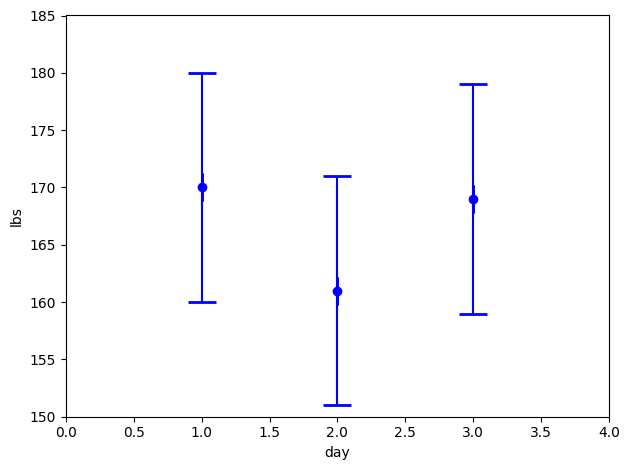

In [ ]:
#     with figsize(y=3.5):
import matplotlib.pyplot as plt
plt.figure()
plt.errorbar([1, 2, 3], [170, 161, 169],
             xerr=0, yerr=10, fmt='bo', capthick=2, capsize=10)
plt.xlim(0,4); plt.ylim(150, 185)
plt.xlabel('day'); plt.ylabel('lbs')
plt.tight_layout()

I could have actually gained weight; maybe my weight on day one was 165 lbs, and on day three it was 172. It is possible to get those weight readings with that weight gain.

My scale tells me I am losing weight, and I am actually gaining weight!

Let's look at that in a chart. I've plotted the measurements along with the error bars, and then some possible weight gain/losses that could be explained by those measurements in dotted green lines.

/content/Kalman-and-Bayesian-Filters-in-Python/kf_book/gh_internal.py:140: SyntaxWarning: invalid escape sequence '\h'
  plt.text (0.0, 159.8, "last estimate ($\hat{x}_{t-1}$)", ha='left', va='top',fontsize=18)
/content/Kalman-and-Bayesian-Filters-in-Python/kf_book/gh_internal.py:166: SyntaxWarning: invalid escape sequence '\h'
  plt.text (0, 159.8, "last estimate ($\hat{x}_{t-1}$)", ha='left', va='top',fontsize=18)
/content/Kalman-and-Bayesian-Filters-in-Python/kf_book/gh_internal.py:167: SyntaxWarning: invalid escape sequence '\h'
  plt.text (0.95, est_y, "estimate ($\hat{x}_{t}$)", ha='right', va='center',fontsize=18)


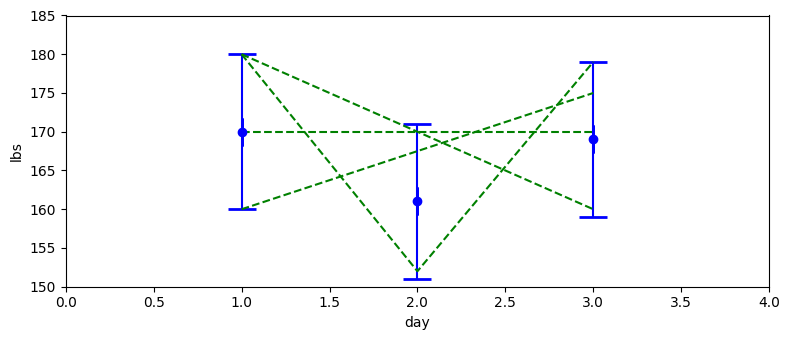

In [ ]:
import kf_book.gh_internal as gh
gh.plot_hypothesis1()

As we can see there is an extreme range of weight changes that could be explained by these three measurements.

In fact, there are an infinite number of choices.

Shall we give up?

Not me!

Recall that we are talking about measuring a human's weight.

There is no reasonable way for a human to weigh 180 lbs on day 1 and 160 lbs on day 3. or to lose 30 lbs in one day only to gain it back the next

(we will assume no amputations or other trauma has happened to the person).

The behavior of the physical system we are measuring should influence how we interpret the measurements.

If we were weighing a rock each day we'd attribute all of the variance to noise.

If we were weighing a cistern fed by rain and used for household chores we might believe such weight changes are real.


Suppose I take a different scale, and I get the following measurements: 169, 170, 169, 171, 170, 171, 169, 170, 169, 170.

What does your intuition tell you?

It is possible, for example, that you gained 1 lb each day, and the noisy measurements just happens to look like you stayed the same weight.

Equally, you could have lost 1 lb a day and gotten the same readings.

But is that likely?

How likely is it to flip a coin and get 10 heads in a row?

Not very likely. We can't prove it based solely on these readings, but it seems pretty likely that my weight held steady.

In the chart below I've plotted the measurements with error bars, and a likely true weight in dashed green. This dashed line is not meant to be the 'correct' answer to this problem, merely one that is reasonable and could be explained by the measurement.

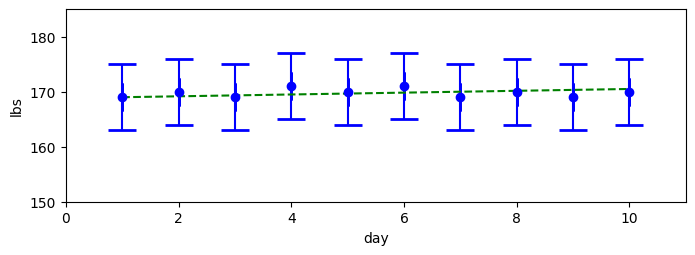

In [ ]:
gh.plot_hypothesis2()

Another what if: what if the readings were 158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0? Let's look at a chart of that and then answer some questions.

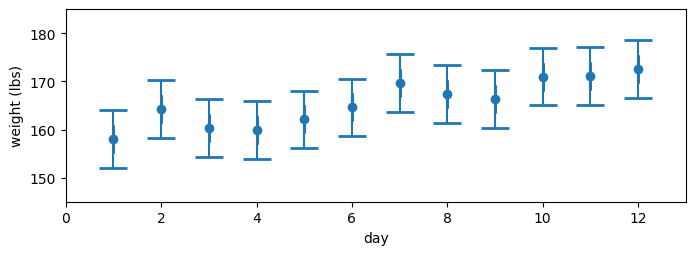

In [ ]:
gh.plot_hypothesis3()

Does it 'seem' likely that I lost weight and this is just really noisy data?

Not really.

Does it seem likely that I held the same weight?

Again, no.

This data trends upwards over time; not evenly, but definitely upwards.

We can't be sure, but that looks like a weight gain, and a significant weight gain at that.

Let's test this assumption with some more plots. It is often easier to 'eyeball' data in a chart versus a table.

So let's look at two hypotheses. First, let's assume our weight did not change. To get that number we agreed that we should average the measurements. Let's look at that.

In [ ]:
gh.plot_hypothesis4()

That doesn't look very convincing. In fact, we can see that there is no horizontal line that we could draw that is inside all of the error bars.

Now, let's assume we gained weight.

How much?

I don't know, but NumPy does!

We want to draw a line through the measurements that looks 'about' right.

NumPy has functions that will do this according to a rule called "least squares fit". Let's not worry about the details of that computation (I use [polyfit()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) if you are interested), and just plot the results.

In [ ]:
gh.plot_hypothesis5()

This looks much better, at least to my eyes. Notice now the hypothesis lies very close to each measurement, whereas in the previous plot the hypothesis was often quite far from the measurement.

It seems far more likely to be true that I gained weight than I didn't gain any weight.

Did I actually gain 13 lbs? Who can say? That seems impossible to answer.

"But is it impossible?" pipes up a co-worker.

Let's try something crazy.

Let's assume that I know I am gaining about one lb a day.

It doesn't matter how I know that right now, assume I know it is approximately correct.

Maybe I am on a 6000 calorie a day diet, which would result in such a weight gain.

Or maybe there is another way to estimate the weight gain. This is a thought experiment, the details are not important. Let's see if we can make use of such information if it was available.

The first measurement was 158. We have no way of knowing any different, so let's accept that as our estimate.

If our weight today is 158, what will it be tomorrow?

Well, we think we are gaining weight at 1 lb/day, so our prediction is 159, like so:

In [ ]:
gh.plot_estimate_chart_1()

Okay, but what good is this? Sure, we could assume the 1 lb/day is accurate, and predict our weight for the next 10 days, but then why use a scale at all if we don't incorporate its readings? So let's look at the next measurement. We step on the scale again and it displays 164.2 lbs.

In [ ]:
gh.plot_estimate_chart_2()

We have a problem. Our prediction doesn't match our measurement.

But, that is what we expected, right?

If the prediction was always exactly the same as the measurement, it would not be capable of adding any information to the filter.

And, of course, there would be no reason to ever measure since our predictions are perfect.

> **The key insight to this entire book is in the next paragraph. Read it carefully!**

So what do we do?

If we only form estimates from the measurement then the prediction will not affect the result.

If we only form estimates from the prediction then the measurement will be ignored.

If this is to work we need to take some kind of **blend of the prediction and measurement** (I've bolded the key point).

Blending two values - this sounds a lot like the two scale problem earlier.

Using the same reasoning as before we can see that the only thing that makes sense is to choose a number between the prediction and the measurement.

For example, an estimate of 165 makes no sense, nor does 157. Our estimates should lie between 159 (the prediction) and 164.2 (the measurement).

One more time, this is so important.

We agreed that when presented two values with errors, we should form an estimate part way between the two values. It does not matter how those values were generated.

In the start of the chapter we had two measurements, but now we have one measurement and one prediction.

The reasoning, and hence the math is the same in both cases.

We *never* throw information away.

I mean it.

I see so much commercial software that throws away noisy data.

Don't do it!

Our prediction of a weight gain might not be very accurate, but so long as there is some information we should use it.

I have to insist you stop and really think about this.

All I have done is replaced an inaccurate scale with an inaccurate weight prediction based on human physiology.

It is still data. Math doesn't know if the data came from a scale or a prediction.

We have two pieces of data with a certain amount of noise, and we want to combine them.

In the remainder of this book we are going to develop some fairly complicated math to perform this computation, but the math never cares where the data come from, it only makes computations based on the value and accuracy of those values.

Should the estimate be half way between the measurement and prediction?

Maybe, but in general it seems like we might know that our prediction is more or less accurate compared to the measurements.

Probably the accuracy of our prediction differs from the accuracy of the scale.

Recall what we did when scale A was much more accurate than scale B - we scaled the answer to be closer to A than B. Let's look at that in a chart.

In [ ]:
gh.plot_estimate_chart_3()


Now let's try a randomly chosen number to scale our estimate: $\frac{4}{10}$.

Our estimate will be four tenths the measurement and the rest will be from the prediction.

In other words, we are expressing a belief here, a belief that the prediction is somewhat more likely to be correct than the measurement. We compute that as

$$\mathtt{estimate} = \mathtt{prediction} + \frac{4}{10}(\mathtt{measurement} - \mathtt{prediction})$$


The difference between the measurement and prediction is called the *residual*, which is depicted by the black vertical line in the plot above.

This will become an important value to use later on, as it is an exact computation of the difference between measurements and the filter's output.

Smaller residuals imply better performance.

Let's code that and see the results when we test it against the series of weights from above.

We have to take into account one other factor.

Weight gain has units of lbs/time, so to be general we will need to add a time step $t$, which we will set to 1 (day).

I hand generated the weight data to correspond to a true starting weight of 160 lbs, and a weight gain of 1 lb per day.

In other words on the first day (day zero) the true weight is 160lbs, on the second day (day one, the first day of weighing) the true weight is 161 lbs, and so on.

We need to make a guess for the initial weight. It is too early to talk about initialization strategies, so for now I will assume 160 lbs.

In [ ]:
from kf_book.book_plots import figsize
import matplotlib.pyplot as plt

weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6,
           169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

time_step = 1.0  # day
scale_factor = 4.0/10

def predict_using_gain_guess(weight, gain_rate, do_print=False):
    # store the filtered results
    estimates, predictions = [weight], []

    # most filter literature uses 'z' for measurements
    for z in weights:
        # predict new position
        prediction = weight + (gain_rate * time_step)

        # update filter
        weight = prediction + (scale_factor * (z - prediction))

        # save
        estimates.append(weight)
        predictions.append(prediction)
        if do_print:
            gh.print_results(estimates, prediction, weight)

    return estimates, predictions

initial_guess = 160.

estimates, predictions = predict_using_gain_guess(
    weight=initial_guess, gain_rate=1, do_print=True)

previous estimate: 160.00, prediction: 161.00, estimate 159.80
previous estimate: 159.80, prediction: 160.80, estimate 162.16
previous estimate: 162.16, prediction: 163.16, estimate 162.02
previous estimate: 162.02, prediction: 163.02, estimate 161.77
previous estimate: 161.77, prediction: 162.77, estimate 162.50
previous estimate: 162.50, prediction: 163.50, estimate 163.94
previous estimate: 163.94, prediction: 164.94, estimate 166.80
previous estimate: 166.80, prediction: 167.80, estimate 167.64
previous estimate: 167.64, prediction: 168.64, estimate 167.75
previous estimate: 167.75, prediction: 168.75, estimate 169.65
previous estimate: 169.65, prediction: 170.65, estimate 170.87
previous estimate: 170.87, prediction: 171.87, estimate 172.16


In [ ]:
# plot results
gh.plot_gh_results(weights, estimates, predictions)

That is pretty good! There is a lot of data here, so let's talk about how to interpret it.  The thick blue line shows the estimate from the filter. It starts at day 0 with the initial guess of 160 lbs. The red line shows the prediction that is made from the previous day's weight. So, on day one the previous weight was 160 lbs, the weight gain is 1 lb, and so the first prediction is 161 lbs.

The estimate on day one is then part way between the prediction and measurement at 159.8 lbs. Below the chart is a print out of the previous weight, predicted weight, and new estimate for each day. Finally, the thin black line shows the actual weight gain of the person being weighed.

Walk through this for each day, ensuring you understand how the prediction and estimates were formed at each step. Note how the estimate always falls between the measurement and prediction.

The estimates are not a straight line, but they are straighter than the measurements and somewhat close to the trend line we created. Also, it seems to get better over time.

The results of the filter may strike you as quite silly;

of course the data will look good if we assume the conclusion, that our weight gain is around 1 lb/day!

Let's see what the filter does if our initial guess is bad.

Let's predict that there is a weight loss of 1 lb a day:

In [ ]:
e, p = predict_using_gain_guess(initial_guess, -1.)
gh.plot_gh_results(weights, e, p)

That is not so impressive. The estimates quickly divert from the measurements.

Clearly a filter that requires us to correctly guess a rate of change is not very useful.

Even if our initial guess was correct, the filter will fail as soon as that rate of change changes.

If I stop overeating the filter will have extreme difficulty in adjusting to that change. Note that it is adjusting! The estimates are climbing even though we tell it we are losing 1 lb a day. It just can't adjust fast enough.

But, 'what if'? What if instead of leaving the weight gain at the initial guess of 1 lb (or whatever), we compute it from the existing measurements and estimates.

On day one our estimate for the weight is:

$$
(160 + 1) + \frac{4}{10}(158-161) = 159.8
$$

On the next day we measure 164.2, which implies a weight gain of 4.4 lbs (since 164.2 - 159.8 = 4.4), not 1.

Can we use this information somehow?

It seems plausible. After all, the weight measurement itself is based on a real world measurement of our weight, so there is useful information.

Our estimate of our weight gain may not be perfect, but it is surely better than just guessing our gain is 1 lb.

Data is better than a guess, even if it is noisy.

People really balk at this point, so make sure you are in agreement.

Two noisy measurements of weight give us an implied weight gain/loss.

That estimate is going to be very inaccurate if the measurements are inaccurate, but there is still information in this computation.

<img src="cow_scale.jpeg">

Imagine weighing a cow with a scale accurate to 1 lb, and it shows that the cow gained 10 lbs.

The cow might have gained 8 lbs up to 12 lbs, depending on the errors, but we know it gained weight, and roughly how much.

This is information. What do we do with information? Never throw it away!

Back to my diet. Should we set the new gain/day to 4.4 lbs?

Yesterday we thought the weight gain was 1 lb, today we think it is 4.4 lbs.

We have two numbers, and want to combine them somehow.

Hmm, sounds like our same problem again.

Let's use our same tool, and the only tool we have so far - pick a value part way between the two.

This time I will use another arbitrarily chosen number, $\frac{1}{3}$.

The equation is identical as for the weight estimate except we have to incorporate time because this is a rate (gain/day):

$$\text{new gain} = \text{old gain} + \frac{1}{3}\frac{\text{measurement - predicted weight}}{1 \text{ day}}
$$

In [ ]:
weight = 160.  # initial guess
gain_rate = -1.0  # initial BAD guess

time_step = 1.
weight_scale = 4./10
gain_scale = 1./3
estimates = [weight]
predictions = []

for z in weights:
#     print(gain_rate)
    # prediction step
    weight = weight + (gain_rate*time_step)
    gain_rate = gain_rate
    predictions.append(weight)

    # update step
    residual = z - weight

    gain_rate = gain_rate + (gain_scale   * (residual/time_step))
    weight    = weight    + (weight_scale * residual)

    estimates.append(weight)

gh.plot_gh_results(weights, estimates, predictions)

I think this is starting to look really good.

Because of the poor initial guess of the weight gain being -1 it takes the filter several days to accurately predict the weight, but once it does that it starts to accurately track the weight.

We used no methodology for choosing our scaling factors of $\frac{4}{10}$ and $\frac{1}{3}$ (actually, they are poor choices for this problem), but otherwise all of the math followed from very reasonable assumptions.

Recall that you can change the value of the parameter `time_step` to a larger value and re-run the cell if you want to see the plot drawn step-by-step.

One final point before we go on. In the prediction step I wrote the line
```python
gain_rate = gain_rate
```

This obviously has no effect, and can be removed.

I wrote this to emphasize that in the prediction step you need to predict the next value for all variables, both `weight` and `gain_rate`. This will become relevant shortly.

In this case we are assuming that the gain does not vary, but when we generalize this algorithm we will remove that assumption.

## Summary

We used noisy measurements collected by a scale to develop intuition on
- why the filtering is needed and
- how we can track the dynamic track changes in noisy data

We are now ready to implement the generic g-h filter.

⚖️ Example 1: Car fuel gauge
- Model (prediction): You know your car burns about 0.05 gallons per mile. After 100 miles, you predict ~5 gallons used.
- Measurement: The fuel gauge says you’ve only used 4 gallons (but you know it’s noisy).
- Insight: Instead of trusting only the model (which ignores hills, traffic, etc.) or only the gauge (which is jittery), the filter blends both.

⸻

🌦 Example 2: Weather forecast vs thermometer
- Model (prediction): The weather app says it should be ~72°F this afternoon.
- Measurement: Your cheap outdoor thermometer reads 70°F, but it’s often off by a few degrees.
- Insight: The “truth” is likely between the two, weighted by how much you trust each source.

⸻

🚌 Example 3: Tracking a bus arrival
- Model (prediction): The bus schedule says it arrives at 8:10am.
- Measurement: The GPS app says it’s 5 minutes away — but GPS sometimes lags.
- Insight: A good estimate blends both: if traffic is light (model reliable), lean toward schedule; if GPS is consistent (measurement reliable), lean toward that.

⸻

🏃 Example 4: Step counter + GPS
- Model (prediction): Your fitness tracker counts steps to estimate distance (say ~0.8m per step).
- Measurement: GPS gives you a noisy location every few seconds.
- Insight: Combine step model + GPS readings → smooth, accurate tracking.
